# Phase 1


In [ ]:
import os

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = '.'

In [ ]:
!kaggle competitions download -c nlp-getting-started

  0% 0.00/593k [00:00<?, ?B/s]
100% 593k/593k [00:00<00:00, 116MB/s]


In [ ]:
!unzip nlp-getting-started.zip -d data

Archive:  nlp-getting-started.zip
  inflating: data/sample_submission.csv  
  inflating: data/test.csv           
  inflating: data/train.csv          


In [ ]:
import pandas as pd

In [ ]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
sub = pd.read_csv('data/sample_submission.csv')

## Explore Dataset

In [ ]:
# lets chech if there any NAN rows
def chec_nan(df):
    return df.isna().any()


In [ ]:
chec_nan(train[['text', 'target']])

text      False
target    False
dtype: bool

In [ ]:
chec_nan(test['text'])

False

## there is some information from the keywords and i wanna make use of it somehow

In [ ]:
train['keyword'].value_counts()

keyword
fatalities               45
deluge                   42
armageddon               42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: count, Length: 221, dtype: int64

In [ ]:
top = train.groupby('keyword')['id'].count()
top = pd.DataFrame({'keyword':top.index,'count':top.values}).sort_values(by=['count']).tail(20)


In [ ]:
bottom = train.groupby('keyword')['id'].count()
bottom = pd.DataFrame({'keyword':bottom.index,'count':bottom.values}).sort_values(by=['count']).head(20)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

221 total unique keywords/toplam benzersiz anahtar kelimeler


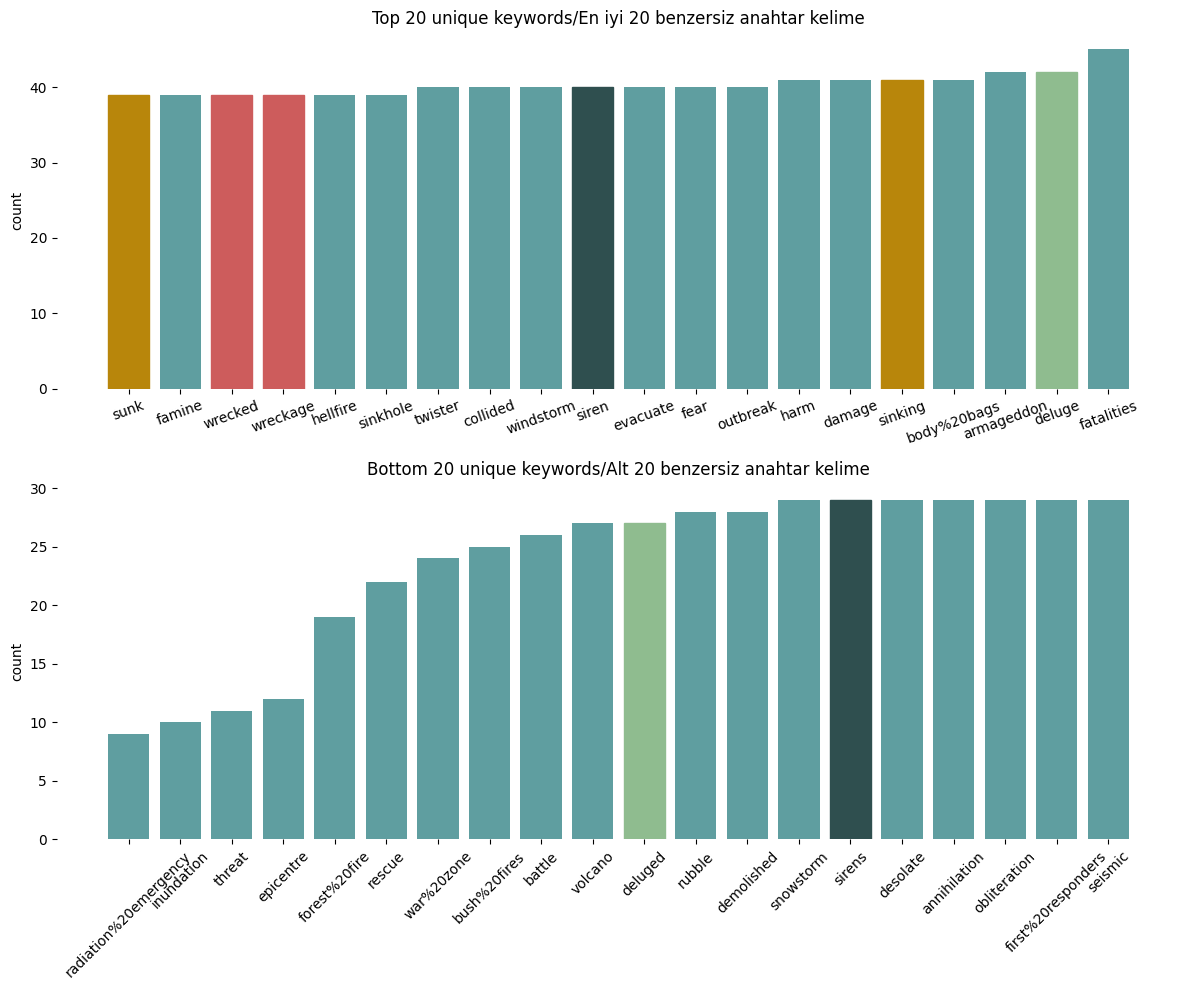

In [ ]:
plt.figure(figsize=(12,10))

plt.subplot(211)
barlist = plt.bar(data=top, x = 'keyword',height = 'count',color = 'cadetblue')
plt.xticks(rotation = 20);
plt.ylabel('count')
plt.title('Top 20 unique keywords/En iyi 20 benzersiz anahtar kelime')
barlist[0].set_color('darkgoldenrod');
barlist[2].set_color('indianred');
barlist[3].set_color('indianred');
barlist[15].set_color('darkgoldenrod');
barlist[9].set_color('darkslategrey');
barlist[18].set_color('darkseagreen');

plt.subplot(212)
barlist = plt.bar(data=bottom, x = 'keyword',height = 'count', color = 'cadetblue');
plt.xticks(rotation = 45);
plt.ylabel('count');
plt.title('Bottom 20 unique keywords/Alt 20 benzersiz anahtar kelime')
barlist[14].set_color('darkslategrey');
barlist[10].set_color('darkseagreen');

sns.despine(left = True, bottom  = True)
plt.tight_layout()

print(str(train['keyword'].nunique())+ ' total unique keywords/toplam benzersiz anahtar kelimeler')

1. fatalities was the highest keyword with around 42 tweets containing keyword. radiation emergency was the least with around 9 tweets containing it.¶
2. From the top20 we can see wrecked and wreckage as different keywords but both mean the same, just tense is different. There are other keywords also present in same format eg: dead, death, annihilation, annihilated, sunk, sinking etc.
3. same colors are given to repeated words with different tenses
Text handling to be done

# Phase 2 - Prepare the Dataset


## Preprocess

1. Repalce missing in keyword and location column with None
2. In keyword column lemmatize and change values with same meaninig into a single value.
3. IN keyword repalce the '%20' in text with some thing else
change the same locations into one eg : 'New York, NY' and 'New York' both are same.
4. tags representing cities, incidents @ notations and http links to handle
5. Special characters like ' -, => , .,: ' are also present to handle.
6. Special symbols like '\x89UO' are present might be emotes need to be removed ### --------------------------------------------------------------------------------------------

In [ ]:
import re

In [ ]:
import re

def clean_text(text):
    # Remove emojis
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)

    # Remove URLs
    url = re.compile(r'https?://\S+|www\.\S+')
    text = url.sub(r'', text)

    # Remove hashtags and mentions
    text = text.replace('#', ' ')
    text = text.replace('@', ' ')

    # Remove all non-alphabetic characters, spaces, and digits
    symbols = re.compile(r'[^A-Za-z ]|\d')
    text = symbols.sub(r'', text)

    return text


In [ ]:
clean_text('13,000 people receive #wildfires evacuation')

' people receive  wildfires evacuation'

In [ ]:
train['keyword'].fillna('None', inplace=True)
train['location'].fillna('None', inplace=True)
train['keyword'] = train['keyword'].str.replace('%20','')

In [ ]:
train.head()

,id,keyword,location,text,target
0,1,None,None,Our Deeds are the Reason of this #earthquake M...,1
1,4,None,None,Forest fire near La Ronge Sask. Canada,1
2,5,None,None,All residents asked to 'shelter in place' are ...,1
3,6,None,None,"13,000 people receive #wildfires evacuation or...",1
4,7,None,None,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
chec_nan(train[['keyword', 'location']])

keyword     False
location    False
dtype: bool

In [ ]:
train['text'] = train['text'].apply(clean_text)

In [ ]:
train.head()

,id,keyword,location,text,target
0,1,None,None,Our Deeds are the Reason of this earthquake M...,1
1,4,None,None,Forest fire near La Ronge Sask Canada,1
2,5,None,None,All residents asked to shelter in place are be...,1
3,6,None,None,people receive wildfires evacuation orders i...,1
4,7,None,None,Just got sent this photo from Ruby Alaska as ...,1


In [ ]:
train['keyword'] = train['keyword'].apply(clean_text)

## Creating Vocab

In [ ]:
import nltk
from nltk.corpus import stopwords

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
stop_words = stopwords.words('english')

In [ ]:
filtered_stopwords = stop_words[:116]

In [ ]:
', '.join(filtered_stopwords)

"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such"

In [ ]:
def add_to_filtered_stopwords(words):
    """
    This function takes a list of words and appends each word to the filtered_stopwords list.

    Parameters:
    words (list): A list of words to be added to filtered_stopwords.
    """
    if not isinstance(words, list):
        raise ValueError("Input must be a list of words.")

    for word in words:
        filtered_stopwords.append(word)

    print("Filtered stopwords updated with the following words:")
    print(', '.join(filtered_stopwords))


In [ ]:
add_to_filtered_stopwords(['https', 'http', 'https'])

Filtered stopwords updated with the following words:
i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, https, http, https


In [ ]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize

In [ ]:
nltk.download('wordnet')
nltk.download('omw-1.4')

# Initialize the WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Phase 3 - Building Model

In [ ]:
def keyword_collector(train_data):
    '''
    this function populates a list of keywords that has a positive correlation with the target variable.
    '''
    keyword_list = []
    keywords = train_data['keyword'].unique()

    for keyword in keywords:
        keyword_tweets = train_data[(train_data['keyword'] == keyword) & (train_data['target'] == 1)]

        for index, row in keyword_tweets.iterrows():
            if keyword in row['text']:
                keyword_list.append(keyword)
                break  # Break out of inner loop once keyword is found

    return keyword_list

In [ ]:
disaster_keywords = keyword_collector(train)

In [ ]:
len(disaster_keywords)

186

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# Concatenate 'text' and 'keyword' columns
train['combined_text'] = train['text'] + ' ' + train['keyword'].fillna('')

# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000,
                                   stop_words='english',
                                   ngram_range=(1,2))


In [ ]:
tfidf_vectorizer.fit(train['combined_text'])

TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words='english')

In [ ]:
tfidf_vectorizer.get_feature_names_out()[:100]

array(['aa', 'aba', 'aba woman', 'abandoned', 'abandoned aircraft',
       'abbswinston', 'abbswinston zionist', 'abc', 'abc news', 'abcnews',
       'ability', 'ablaze', 'ablaze ablaze', 'able', 'absolutely',
       'abstorm', 'abuse', 'access', 'access secrets', 'accident',
       'accident accident', 'accident airplaneaccident',
       'accident experts', 'accident man', 'accident property',
       'accidentally', 'accidents', 'accidents indian', 'according',
       'account', 'accused', 'accuses', 'acres', 'act', 'action',
       'actions', 'actions year', 'activated', 'activates', 'active',
       'activity', 'acts', 'actual', 'actually', 'add', 'added',
       'added video', 'address', 'admits', 'admits arson', 'adult',
       'advance', 'advisory', 'af', 'affected', 'affected fatal',
       'afghan', 'afghanistan', 'afraid', 'africa', 'afterlife',
       'afternoon', 'aftershock', 'aftershock aftershock',
       'aftershock djicemoon', 'age', 'ago', 'ago today', 'agree',
       

In [ ]:
inputs = tfidf_vectorizer.transform(train.combined_text)

In [ ]:
inputs.shape

(7613, 5000)

In [ ]:
def custom_tokenizer(text):
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    keyword_weight = 1.5  # Adjust this weight based on keyword importance

    # Remove stop words
    tokens = [lemmatizer.lemmatize(token.lower()) for token in tokens if token.lower() not in stop_words]

    # Increase TF-IDF weight for specific keywords related to disasters
    for keyword in disaster_keywords:
        if keyword in tokens:
            idx = tokens.index(keyword)
            inputs[0, idx] *= keyword_weight  # Adjust TF-IDF score for the keyword

    return tokens

In [ ]:
# Initialize TF-IDF vectorizer with custom tokenizer
tfidf_vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, max_features=3000, stop_words='english')

# Fit TF-IDF on 'text' column
inputs = tfidf_vectorizer.fit_transform(train['text'])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['le', 'u'] not in stop_words.
  warnings.warn(


In [ ]:
test.shape

(3263, 4)

In [ ]:
test_inputs = tfidf_vectorizer.transform(test.text)

/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split

In [ ]:
train_inputs, val_inputs, train_targets, val_targets = train_test_split(inputs, train['target'], test_size=0.3, random_state=42)

In [ ]:
model = LogisticRegression()

In [ ]:
# Define the parameter grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
    'solver': ['sag', 'saga', 'lbfgs'],  # Optimization algorithms
    'penalty': ['l2']  # Regularization types
}

# Instantiate the GridSearchCV
grid_search = GridSearchCV(estimator=LogisticRegression(random_state=42),
                           param_grid=param_grid,
                           scoring='f1',
                           cv=15,
                           verbose=1,
                           n_jobs=-1)

grid_search.fit(train_inputs, train_targets)

Fitting 15 folds for each of 18 candidates, totalling 270 fits


GridSearchCV(cv=15, estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l2'],
                         'solver': ['sag', 'saga', 'lbfgs']},
             scoring='f1', verbose=1)

In [ ]:
# Evaluate the best model on the test set
best_model = grid_search.best_estimator_

y_pred = best_model.predict(val_inputs)
print("\nTest Set F1 Score:")
print(f1_score(val_targets, y_pred))


Test Set F1 Score:
0.7453204764605788


In [ ]:
test_preds = best_model.predict(test_inputs)

In [ ]:
sub['target'] = test_preds

In [ ]:
sub.to_csv('submission_flr.csv', index=False)